In [2]:
import os;
import json;
import builtins
import duckdb
import pandas as pd;
import matplotlib.pyplot as plt

def get_dataset_from_testcase(run):
    return run[0:-2]

dir = '/home/chesetti/Repos/learned_merge_cleanup/sponge/join_all'
runs = []
for test_case in os.listdir(dir):
    if test_case == 'build':
        continue
    for run_name in os.listdir(os.path.join(dir, test_case, 'outputs', 'results', 'run')):
        json_file = builtins.open(os.path.join(dir, test_case, 'outputs', 'results', 'run', run_name))
        run = (json.load(json_file))
        run['dataset'] = get_dataset_from_testcase(test_case)
        runs.append(run)
df = pd.json_normalize(runs)
print(df.columns)
display(df)

Index(['command', 'dataset', 'result.checksum', 'result.duration_ns',
       'result.duration_sec', 'result.inner_disk_fetch',
       'result.inner_disk_fetch_size', 'result.inner_total_bytes_fetched',
       'result.num_output_keys', 'result.outer_disk_fetch',
       'result.outer_disk_fetch_size', 'result.outer_total_bytes_fetched',
       'spec.algo', 'spec.algo_name', 'spec.check_checksum', 'spec.common_key',
       'spec.index.epsilon', 'spec.index.leaf_size_in_pages',
       'spec.index.search', 'spec.index.type', 'spec.inner_table',
       'spec.key_size', 'spec.key_type', 'spec.load_sstable_in_mem',
       'spec.name', 'spec.num_threads', 'spec.outer_table', 'spec.result_path',
       'spec.value_size', 'spec.write_result_to_disk'],
      dtype='object')


,command,dataset,result.checksum,result.duration_ns,result.duration_sec,result.inner_disk_fetch,result.inner_disk_fetch_size,result.inner_total_bytes_fetched,result.num_output_keys,result.outer_disk_fetch,...,spec.inner_table,spec.key_size,spec.key_type,spec.load_sstable_in_mem,spec.name,spec.num_threads,spec.outer_table,spec.result_path,spec.value_size,spec.write_result_to_disk
0,numactl -N 1 -m 1 sponge/join_all/build/benchm...,fb,37FC5C182B197FF06811E9D7701E605F,1481070595,1.481071,48829,65536,3199999984,1989990,7774,...,sponge/join_all/fb_1/inputs/inner,8,uint64,False,lsj_btree4096100run_1,1,sponge/join_all/fb_1/inputs/input100,sponge/join_all/fb_1/outputs/lsj_btree4096_run...,8,True
1,numactl -N 1 -m 1 sponge/join_all/build/benchm...,fb,972CC95E6631904D8287EE4B23FBE0F1,5365979627,5.365980,317998,69632,22142752720,19031039,74340,...,sponge/join_all/fb_1/inputs/inner,8,uint64,False,inlj_sampledflatpgm409610run_0,1,sponge/join_all/fb_1/inputs/input10,sponge/join_all/fb_1/outputs/inlj_sampledflatp...,8,True
2,numactl -N 1 -m 1 sponge/join_all/build/benchm...,fb,90821B94D6A6E903EBEC6EA236EB68A2,14757411439,14.757411,781250,4096,3199999984,199913,0,...,sponge/join_all/fb_1/inputs/inner,8,uint64,False,hash_join1000run_2,1,sponge/join_all/fb_1/inputs/input1000,sponge/join_all/fb_1/outputs/hash_join_run_2_r...,8,True
3,numactl -N 1 -m 1 sponge/join_all/build/benchm...,fb,972CC95E6631904D8287EE4B23FBE0F1,5537933558,5.537934,221943,69632,15454316112,19031039,74340,...,sponge/join_all/fb_1/inputs/inner,8,uint64,False,inlj_pgm409610run_0,1,sponge/join_all/fb_1/inputs/input10,sponge/join_all/fb_1/outputs/inlj_pgm4096_run_...,8,True
4,numactl -N 1 -m 1 sponge/join_all/build/benchm...,fb,972CC95E6631904D8287EE4B23FBE0F1,4389005845,4.389006,781250,4096,3199999984,19031039,74340,...,sponge/join_all/fb_1/inputs/inner,8,uint64,False,sort_join10run_0,1,sponge/join_all/fb_1/inputs/input10,sponge/join_all/fb_1/outputs/sort_join_run_0_r...,8,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,numactl -N 1 -m 1 sponge/join_all/build/benchm...,wiki,985AD79CA52B42BBF980947E772AC147,649332115,0.649332,20781,69632,1446975792,1968997,7692,...,sponge/join_all/wiki_1/inputs/inner,8,uint64,False,lsj_sampledflatpgm4096100run_2,1,sponge/join_all/wiki_1/inputs/input100,sponge/join_all/wiki_1/outputs/lsj_sampledflat...,8,True
703,numactl -N 1 -m 1 sponge/join_all/build/benchm...,wiki,C6E2640CC75B5FBEC2A3BBADE5D387EB,23636991757,23.636992,353270,4096,1446992176,90437011,353270,...,sponge/join_all/wiki_1/inputs/inner,8,uint64,False,inlj_btree2561run_0,1,sponge/join_all/wiki_1/inputs/input1,sponge/join_all/wiki_1/outputs/inlj_btree256_r...,8,True
704,numactl -N 1 -m 1 sponge/join_all/build/benchm...,wiki,80A82214F3DC31463C732262E3CFA6B1,4416750025,4.416750,20781,69632,1446990624,17262484,67432,...,sponge/join_all/wiki_1/inputs/inner,8,uint64,False,lsj_pgm409610run_0,1,sponge/join_all/wiki_1/inputs/input10,sponge/join_all/wiki_1/outputs/lsj_pgm4096_run...,8,True
705,numactl -N 1 -m 1 sponge/join_all/build/benchm...,wiki,80A82214F3DC31463C732262E3CFA6B1,4059837048,4.059837,119781,69632,8340448368,17262484,67432,...,sponge/join_all/wiki_1/inputs/inner,8,uint64,False,inlj_pgm409610run_1,1,sponge/join_all/wiki_1/inputs/input10,sponge/join_all/wiki_1/outputs/inlj_pgm4096_ru...,8,True


In [28]:

epsilon = {
    "pgm256": 256,
    "pgm1024": 1024,
    "pgm2048": 2048,
    "flatpgm256": 256,
    "flatpgm1024": 1024,
    "flatpgm2048": 2048,
    "flatpgm4096": 4096,
    "flatpgm8192": 8192,
    "hashjoin": 0,
    "btree": 0,
    "sj": 0,
    "sj2": 0,
    "standard_merge": 0
};
def indexType(x):
    if "pgm" in x:
        return "PGM"
    elif "btree" in x:
        return "BTREE"
    return "NA"

df["threads"] = df["spec.num_threads"]
df["duration_sec"] = df["result.duration_ns"] / (1000000000)
df["inner_disk_fetch"] = df["result.inner_disk_fetch"]
df['result_num_keys'] = df['result.num_output_keys']
df["ratio"] = df["spec.common_key"]
df["algo"] = df["spec.algo_name"]
df["epsilon"] = df["spec.index.epsilon"]
df["inner_bytes_fetched"] = df["result.inner_total_bytes_fetched"]
df["index_type"] = df["spec.algo_name"].map(lambda x: indexType(x))
df['dataset'].unique()
df['result.num_output_keys'].unique()
duckdb.sql("SELECT ratio, result_num_keys from df WHERE dataset='fb'")


┌───────┬─────────────────┐
│ ratio │ result_num_keys │
│ int64 │      int64      │
├───────┼─────────────────┤
│   100 │         1989990 │
│    10 │        19031039 │
│  1000 │          199913 │
│    10 │        19031039 │
│    10 │        19031039 │
│    10 │        19031039 │
│  1000 │          199913 │
│    10 │        19031039 │
│  1000 │          199913 │
│     1 │       199999999 │
│     · │            ·    │
│     · │            ·    │
│     · │            ·    │
│   100 │         1989990 │
│    10 │        19031039 │
│     1 │       199999999 │
│   100 │         1989990 │
│     1 │       199999999 │
│  1000 │          199913 │
│     1 │       199999999 │
│    10 │        19031039 │
│    10 │        19031039 │
│    10 │        19031039 │
├───────┴─────────────────┤
│   140 rows (20 shown)   │
└─────────────────────────┘

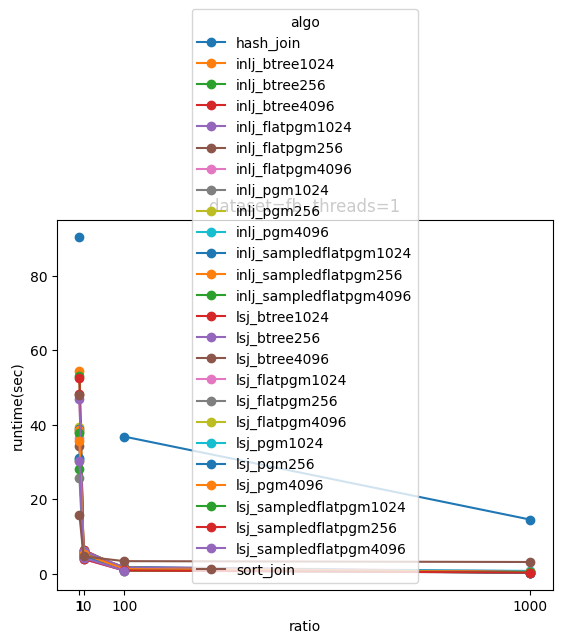

In [5]:
def plot_for_dataset_zoomed(dataset, threads):
    rows = duckdb.sql(
        " SELECT threads, ratio, algo, AVG(duration_sec) as v FROM df"
        f" WHERE dataset='{dataset}' AND algo != 'hj' AND ratio>=50 AND threads={threads}"
        " GROUP BY dataset, threads, ratio, algo"
        " ORDER BY ratio, threads"
    ).df()
    rows = rows.pivot(index='ratio', values='v', columns=['algo'])
    rows.plot(marker='o')
    plt.xlabel('ratio')
    plt.ylabel('runtime(sec)')
    plt.xticks(rows.index)
    plt.title(f'dataset={dataset}, threads={threads}')

def plot_for_dataset(dataset, threads):
    rows = duckdb.sql(
        " SELECT threads, ratio, algo, AVG(duration_sec) as v FROM df"
        f" WHERE dataset='{dataset}' AND threads={threads}"
        " GROUP BY dataset, threads, ratio, algo"
        " ORDER BY ratio, threads"
    ).df()
    rows = rows.pivot(index='ratio', values='v', columns=['algo'])
    rows.plot(marker='o')
    plt.xlabel('ratio')
    plt.ylabel('runtime(sec)')
    plt.xticks(rows.index)
    plt.title(f'dataset={dataset}, threads={threads}')

plot_for_dataset('fb', 1)

In [9]:
rows = duckdb.sql(
    " SELECT ratio, algo, MEDIAN(duration_sec) as v FROM df"
    f" WHERE threads=1 AND (algo='hash_join' OR algo='sort_join' or epsilon='256') AND dataset='wiki'"
    " GROUP BY dataset, threads, ratio, algo"
    " ORDER BY ratio, threads"
).df()
display(rows.pivot(index='ratio', values='v', columns='algo'))

rows = duckdb.sql(
    " SELECT ratio, algo, MEDIAN(duration_sec) as v FROM df"
    f" WHERE threads=1 AND (algo='hash_join' OR algo='sort_join' or epsilon='1024') AND dataset='wiki'"
    " GROUP BY dataset, threads, ratio, algo"
    " ORDER BY ratio, threads"
).df()
display(rows.pivot(index='ratio', values='v', columns='algo'))

rows = duckdb.sql(
    " SELECT ratio, algo, MEDIAN(duration_sec) as v FROM df"
    f" WHERE threads=1 AND (algo='hash_join' OR algo='sort_join' or epsilon='4096') AND dataset='wiki'"
    " GROUP BY dataset, threads, ratio, algo"
    " ORDER BY ratio, threads"
).df()
display(rows.pivot(index='ratio', values='v', columns='algo'))


algo,hash_join,inlj_btree256,inlj_flatpgm256,inlj_pgm256,inlj_sampledflatpgm256,lsj_btree256,lsj_flatpgm256,lsj_pgm256,lsj_sampledflatpgm256,sort_join
ratio,,,,,,,,,,
1,90.378733,53.067202,34.354592,39.261868,38.679797,46.912367,25.746560,31.150178,NaN,15.866133
10,NaN,6.379530,4.538072,5.061264,6.093801,6.201614,4.075511,4.893255,3.827594,4.825520
100,36.821870,1.426807,1.017493,NaN,1.665317,1.639285,NaN,0.960022,0.903443,3.401343
1000,14.543714,0.242198,0.346613,0.352090,0.376749,0.284008,0.333553,0.281462,0.327696,3.173862


algo,hash_join,inlj_btree1024,inlj_flatpgm1024,inlj_pgm1024,inlj_sampledflatpgm1024,lsj_btree1024,lsj_flatpgm1024,lsj_pgm1024,lsj_sampledflatpgm1024,sort_join
ratio,,,,,,,,,,
1,90.378733,54.454780,NaN,38.118781,38.913342,48.148308,NaN,30.874753,28.111472,15.866133
10,NaN,6.049074,5.253616,5.065658,5.623032,6.458570,3.975073,4.634047,NaN,4.825520
100,36.821870,1.509293,NaN,1.581071,1.830595,1.092119,0.856162,0.908022,0.847124,3.401343
1000,14.543714,0.434405,0.448275,0.445012,0.476517,0.471338,0.458789,NaN,0.440094,3.173862


algo,hash_join,inlj_btree4096,inlj_flatpgm4096,inlj_pgm4096,inlj_sampledflatpgm4096,lsj_btree4096,lsj_flatpgm4096,lsj_pgm4096,lsj_sampledflatpgm4096,sort_join
ratio,,,,,,,,,,
1,90.378733,52.560354,36.552882,NaN,37.738168,48.017536,30.219266,35.707858,30.245463,15.866133
10,NaN,5.819146,5.305668,5.694397,5.385961,NaN,4.378235,5.324928,4.299135,4.825520
100,36.821870,1.079053,1.833962,1.412660,1.498292,1.481071,NaN,1.270607,0.870889,3.401343
1000,14.543714,0.610135,0.689003,0.784775,NaN,NaN,0.512758,0.519096,NaN,3.173862


In [16]:
rows = duckdb.sql(
    " SELECT ratio, algo, MEDIAN(inner_disk_fetch) as v FROM df"
    f" WHERE threads=1 AND (algo='hash_join' OR algo='sort_join' or epsilon='256') AND dataset='wiki'"
    " GROUP BY dataset, threads, ratio, algo"
    " ORDER BY ratio, threads"
).df()
display(rows.pivot(index='ratio', values='v', columns='algo'))

rows = duckdb.sql(
    " SELECT ratio, algo, MEDIAN(inner_disk_fetch) as v FROM df"
    f" WHERE threads=1 AND (algo='hash_join' OR algo='sort_join' or epsilon='1024') AND dataset='wiki'"
    " GROUP BY dataset, threads, ratio, algo"
    " ORDER BY ratio, threads"
).df()
display(rows.pivot(index='ratio', values='v', columns='algo'))

rows = duckdb.sql(
    " SELECT ratio, algo, MEDIAN(inner_disk_fetch) as v FROM df"
    f" WHERE threads=1 AND (algo='hash_join' OR algo='sort_join' or epsilon='4096') AND dataset='wiki'"
    " GROUP BY dataset, threads, ratio, algo"
    " ORDER BY ratio, threads"
).df()
display(rows.pivot(index='ratio', values='v', columns='algo'))


algo,hash_join,inlj_btree256,inlj_flatpgm256,inlj_pgm256,inlj_sampledflatpgm256,lsj_btree256,lsj_flatpgm256,lsj_pgm256,lsj_sampledflatpgm256,sort_join
ratio,,,,,,,,,,
1,353270.0,353270.0,490278.0,490278.0,2035989.0,353270.0,176635.0,176635.0,176635.0,353270.0
10,353270.0,353270.0,471233.0,471233.0,1152499.0,353270.0,176611.0,176611.0,176635.0,353270.0
100,353270.0,348977.0,329905.0,329905.0,663675.0,348977.0,172997.0,172997.0,176423.0,353270.0
1000,353270.0,149512.0,108881.0,108881.0,140123.0,149512.0,103037.0,103037.0,118838.0,353269.0


algo,hash_join,inlj_btree1024,inlj_flatpgm1024,inlj_pgm1024,inlj_sampledflatpgm1024,lsj_btree1024,lsj_flatpgm1024,lsj_pgm1024,lsj_sampledflatpgm1024,sort_join
ratio,,,,,,,,,,
1,353270.0,88318.0,309849.0,309849.0,962051.0,88318.0,70654.0,70654.0,70654.0,353270.0
10,353270.0,88318.0,302377.0,302377.0,595066.0,88318.0,70653.0,70653.0,70654.0,353270.0
100,353270.0,88318.0,248774.0,248774.0,393779.0,88318.0,70455.0,70455.0,70644.0,353270.0
1000,353270.0,76642.0,93956.0,93956.0,112086.0,76642.0,60917.0,60917.0,63310.0,353269.0


algo,hash_join,inlj_btree4096,inlj_flatpgm4096,inlj_pgm4096,inlj_sampledflatpgm4096,lsj_btree4096,lsj_flatpgm4096,lsj_pgm4096,lsj_sampledflatpgm4096,sort_join
ratio,,,,,,,,,,
1,353270.0,22080.0,121255.0,121255.0,300521.0,22080.0,20781.0,20781.0,20781.0,353270.0
10,353270.0,22080.0,119781.0,119781.0,185981.0,22080.0,20781.0,20781.0,20781.0,353270.0
100,353270.0,22080.0,108041.0,108041.0,139448.0,22080.0,20778.0,20778.0,20781.0,353270.0
1000,353270.0,22040.0,60751.0,60751.0,67036.0,22040.0,20509.0,20509.0,20578.0,353269.0
